# Deep Learning in Time Series Analysis
Author: Geovanna Santos Nobre de Oliveira

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


2022-10-09 17:01:42.119593: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-09 17:01:42.207117: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-09 17:01:42.210678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 17:01:42.210704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['axes.grid'] = False


In [4]:
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell


In [5]:
print(tf.__version__)


2.10.0


In [6]:
tf.random.set_seed(51)
np.random.seed(51)


## Import and Visualize the Data

### Appliance Energy Dataset

In [7]:
path = 'AppliedTimeSeriesAnalysisWithPython/data'


In [8]:
df = pd.read_csv(f'{path}/energydata_complete.csv')
df.head()


date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1    92.0   6.666667   59.166667        5.2  18.606195  18.606195  
2    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3    92.0   6.000000   51.500000        5.0  45.410389  45.410389  
4    92.0   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

In [9]:
df = df[::6]
df.head()


date  Appliances  lights         T1       RH_1         T2  \
0   2016-01-11 17:00:00          60      30  19.890000  47.596667  19.200000   
6   2016-01-11 18:00:00          60      50  19.890000  45.766667  19.200000   
12  2016-01-11 19:00:00         430      50  20.133333  48.000000  19.566667   
18  2016-01-11 20:00:00          80      30  20.890000  51.193333  20.200000   
24  2016-01-11 21:00:00         110      30  21.133333  46.060000  20.426667   

     RH_2     T3       RH_3         T4  ...         T9       RH_9  T_out  \
0   44.79  19.79  44.730000  19.000000  ...  17.033333  45.530000    6.6   
6   44.50  19.79  44.900000  18.890000  ...  17.000000  45.290000    5.9   
12  44.40  19.89  44.900000  19.000000  ...  16.963333  45.290000    6.0   
18  46.33  20.20  48.193333  18.963333  ...  16.890000  45.200000    6.0   
24  44.76  20.29  46.433333  19.390000  ...  16.890000  44.966667    6.0   

    Press_mm_hg  RH_out  Windspeed  Visibility  Tdewpoint        rv1  \
0         733.5    92.0        7.0        63.0        5.3  13.275433   
6         734.1    92.0        5.0        40.0        4.7  47.233763   
12        734.5    91.0        6.0        40.0        4.6  34.351142   
18        735.2    88.0        6.0        40.0        4.1  19.001759   
24        735.4    87.0        6.0        40.0        3.9  13.361033   

          rv2  
0   13.275433  
6   47.233763  
12  34.351142  
18  19.001759  
24  13.361033  

[5 rows x 29 columns]

In [10]:
df.shape


(3290, 29)

In [11]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d %H:%M:%S')


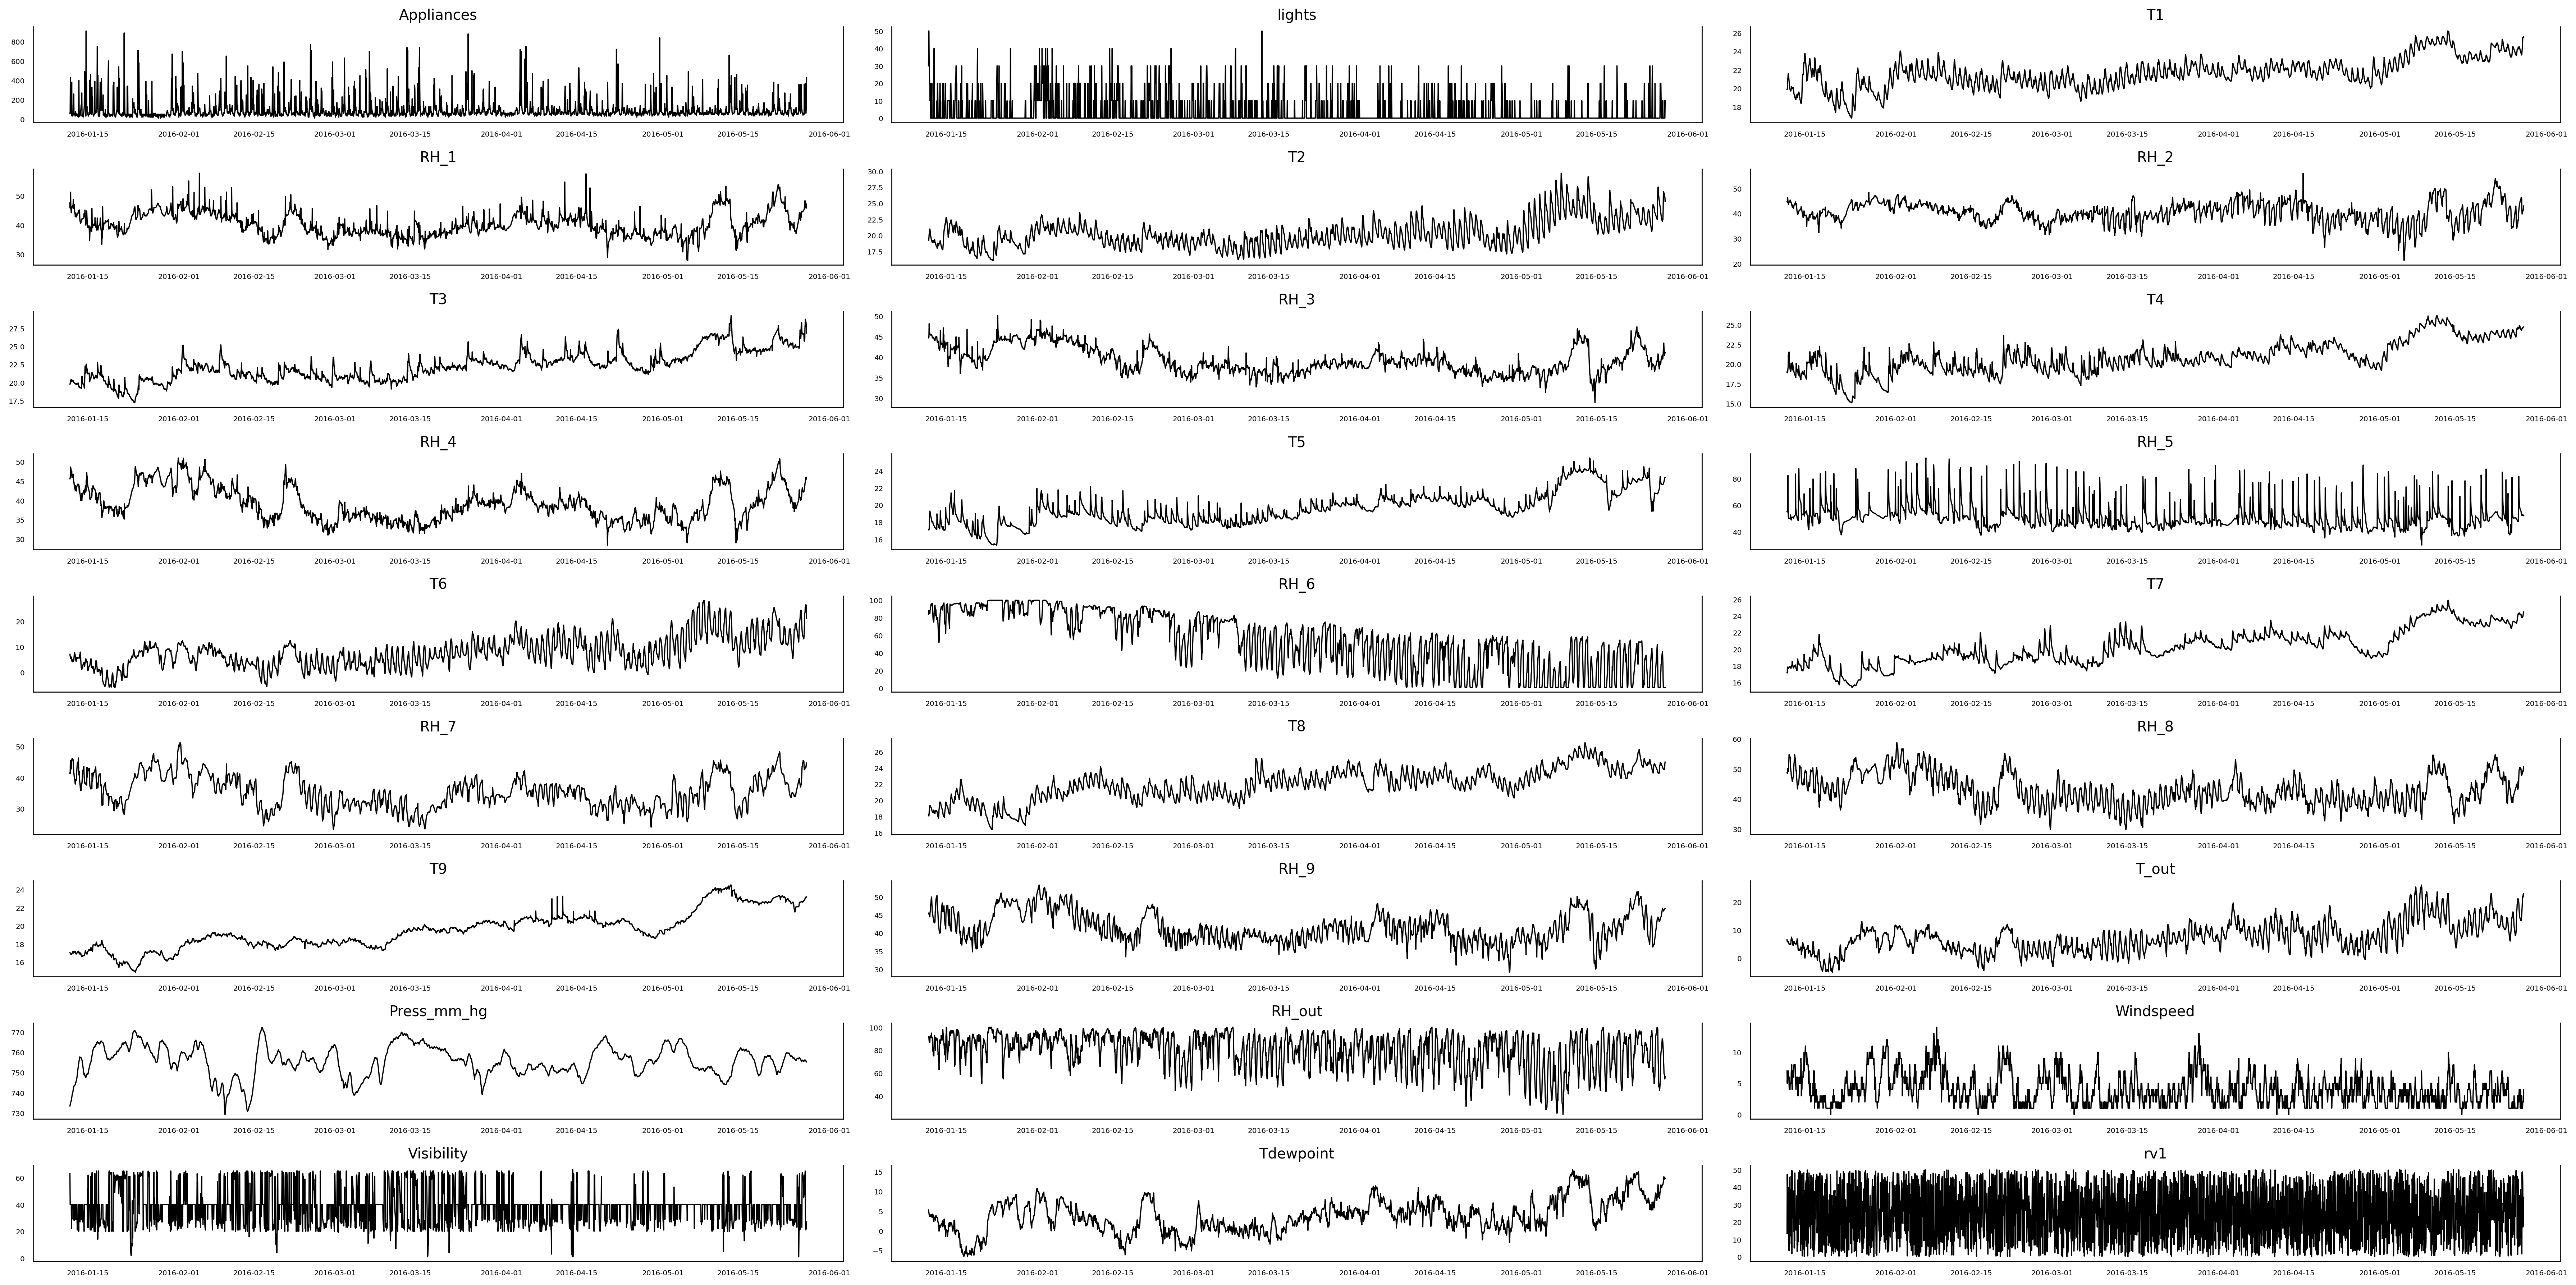

In [12]:
import enum


fig, axes = plt.subplots(nrows=9, ncols=3, dpi=240, figsize=(30, 15))

for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    data.index = date_time
    ax.plot(data, color='black', linewidth=1)

    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()


## EDA - Exploratory Data Analysis

In [13]:
df.describe().transpose()


count        mean         std         min         25%  \
Appliances   3290.0   96.835866  100.459209   10.000000   50.000000   
lights       3290.0    3.802432    7.954943    0.000000    0.000000   
T1           3290.0   21.686138    1.606259   16.790000   20.737500   
RH_1         3290.0   40.262549    3.992042   27.926667   37.372500   
T2           3290.0   20.342054    2.195577   16.100000   18.790000   
RH_2         3290.0   40.423351    4.072868   21.230000   37.888750   
T3           3290.0   22.266861    2.006131   17.200000   20.790000   
RH_3         3290.0   39.241405    3.254206   28.860000   36.900000   
T4           3290.0   20.856308    2.043188   15.100000   19.500000   
RH_4         3290.0   39.026112    4.343764   28.424286   35.527500   
T5           3290.0   19.593729    1.846567   15.335000   18.290000   
RH_5         3290.0   50.976187    9.027893   30.030000   45.407361   
T6           3290.0    7.910692    6.085939   -5.977778    3.602500   
RH_6         3290.0   54.613721   31.151953    1.000000   30.089286   
T7           3290.0   20.266688    2.110084   15.390000   18.710313   
RH_7         3290.0   35.388677    5.116203   23.230000   31.434000   
T8           3290.0   22.028564    1.956713   16.367778   20.790000   
RH_8         3290.0   42.939096    5.223835   29.700000   39.060000   
T9           3290.0   19.485795    2.015741   14.890000   18.000000   
RH_9         3290.0   41.551792    4.154506   29.166667   38.506667   
T_out        3290.0    7.413435    5.333517   -5.000000    3.700000   
Press_mm_hg  3290.0  755.519772    7.405326  729.300000  750.925000   
RH_out       3290.0   79.749088   15.053694   24.000000   70.000000   
Windspeed    3290.0    4.040122    2.491661    0.000000    2.000000   
Visibility   3290.0   38.332523   12.887158    1.000000   28.000000   
Tdewpoint    3290.0    3.762097    4.206752   -6.600000    0.900000   
rv1          3290.0   24.933725   14.635032    0.032817   12.415205   
rv2          3290.0   24.933725   14.635032    0.032817   12.415205   

                    50%         75%         max  
Appliances    60.000000  100.000000  910.000000  
lights         0.000000    0.000000   50.000000  
T1            21.600000   22.600000   26.200000  
RH_1          39.650833   43.090000   57.663333  
T2            20.000000   21.500000   29.663333  
RH_2          40.500000   43.260000   56.026667  
T3            22.100000   23.290000   29.236000  
RH_3          38.537500   41.752500   50.163333  
T4            20.633333   22.100000   26.140000  
RH_4          38.400000   42.152500   50.963333  
T5            19.390000   20.613492   25.466667  
RH_5          49.181667   53.760000   95.608889  
T6             7.331667   11.261667   28.200000  
RH_6          55.346667   83.125833   99.900000  
T7            20.036111   21.600000   25.890000  
RH_7          34.863333   39.000000   51.197778  
T8            22.100000   23.390000   27.133333  
RH_8          42.361667   46.560000   58.780000  
T9            19.390000   20.600000   24.500000  
RH_9          40.900000   44.367262   53.326667  
T_out          6.900000   10.400000   26.100000  
Press_mm_hg  756.100000  760.900000  772.300000  
RH_out        84.000000   92.000000  100.000000  
Windspeed      4.000000    6.000000   14.000000  
Visibility    40.000000   40.000000   66.000000  
Tdewpoint      3.500000    6.600000   15.500000  
rv1           24.820163   37.629171   49.981674  
rv2           24.820163   37.629171   49.981674

In [14]:
# Dropping variables that haveno value in the prediction
drop_cols = ['lights', 'rv1', 'rv2']
df = df.drop(drop_cols, axis=1)


In [15]:
df.shape


(3290, 25)

In [16]:
df.describe().transpose()


count        mean         std         min         25%  \
Appliances   3290.0   96.835866  100.459209   10.000000   50.000000   
T1           3290.0   21.686138    1.606259   16.790000   20.737500   
RH_1         3290.0   40.262549    3.992042   27.926667   37.372500   
T2           3290.0   20.342054    2.195577   16.100000   18.790000   
RH_2         3290.0   40.423351    4.072868   21.230000   37.888750   
T3           3290.0   22.266861    2.006131   17.200000   20.790000   
RH_3         3290.0   39.241405    3.254206   28.860000   36.900000   
T4           3290.0   20.856308    2.043188   15.100000   19.500000   
RH_4         3290.0   39.026112    4.343764   28.424286   35.527500   
T5           3290.0   19.593729    1.846567   15.335000   18.290000   
RH_5         3290.0   50.976187    9.027893   30.030000   45.407361   
T6           3290.0    7.910692    6.085939   -5.977778    3.602500   
RH_6         3290.0   54.613721   31.151953    1.000000   30.089286   
T7           3290.0   20.266688    2.110084   15.390000   18.710313   
RH_7         3290.0   35.388677    5.116203   23.230000   31.434000   
T8           3290.0   22.028564    1.956713   16.367778   20.790000   
RH_8         3290.0   42.939096    5.223835   29.700000   39.060000   
T9           3290.0   19.485795    2.015741   14.890000   18.000000   
RH_9         3290.0   41.551792    4.154506   29.166667   38.506667   
T_out        3290.0    7.413435    5.333517   -5.000000    3.700000   
Press_mm_hg  3290.0  755.519772    7.405326  729.300000  750.925000   
RH_out       3290.0   79.749088   15.053694   24.000000   70.000000   
Windspeed    3290.0    4.040122    2.491661    0.000000    2.000000   
Visibility   3290.0   38.332523   12.887158    1.000000   28.000000   
Tdewpoint    3290.0    3.762097    4.206752   -6.600000    0.900000   

                    50%         75%         max  
Appliances    60.000000  100.000000  910.000000  
T1            21.600000   22.600000   26.200000  
RH_1          39.650833   43.090000   57.663333  
T2            20.000000   21.500000   29.663333  
RH_2          40.500000   43.260000   56.026667  
T3            22.100000   23.290000   29.236000  
RH_3          38.537500   41.752500   50.163333  
T4            20.633333   22.100000   26.140000  
RH_4          38.400000   42.152500   50.963333  
T5            19.390000   20.613492   25.466667  
RH_5          49.181667   53.760000   95.608889  
T6             7.331667   11.261667   28.200000  
RH_6          55.346667   83.125833   99.900000  
T7            20.036111   21.600000   25.890000  
RH_7          34.863333   39.000000   51.197778  
T8            22.100000   23.390000   27.133333  
RH_8          42.361667   46.560000   58.780000  
T9            19.390000   20.600000   24.500000  
RH_9          40.900000   44.367262   53.326667  
T_out          6.900000   10.400000   26.100000  
Press_mm_hg  756.100000  760.900000  772.300000  
RH_out        84.000000   92.000000  100.000000  
Windspeed      4.000000    6.000000   14.000000  
Visibility    40.000000   40.000000   66.000000  
Tdewpoint      3.500000    6.600000   15.500000

## Feature Engineering

### Time

In [17]:
timestamp_s = date_time.map(datetime.datetime.timestamp)


2022-10-09 17:01:49.272174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-09 17:01:49.272513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-09 17:01:49.272550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-09 17:01:49.272571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-09 17:01:49.272592: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

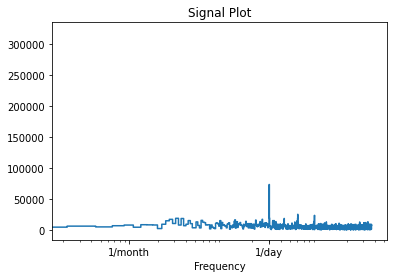

In [18]:
# Seeing if there is a seasonality in the dataset using a Fourier transform
fft = tf.signal.rfft(df['Appliances'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['Appliances'])
hours_per_month = 24 * 30.4167
months_per_dataset = n_sample_h / hours_per_month

f_per_month = f_per_dataset / months_per_dataset

plt.step(f_per_month, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 30.4167], labels=['1/month', '1/day'])
plt.xlabel('Frequency')
plt.title('Signal Plot')
plt.show()


We can see peeks where there is a seasonality. So, we don't have a seasonality over a month, but we do have some kind of seasonality over every day. 

In [19]:
day = 24 * 60 * 60  # 24 hours x 60 minutes x 60 seconds
df['Day sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['Day cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values


In [20]:
df.head()


Appliances         T1       RH_1         T2   RH_2     T3       RH_3  \
0           60  19.890000  47.596667  19.200000  44.79  19.79  44.730000   
6           60  19.890000  45.766667  19.200000  44.50  19.79  44.900000   
12         430  20.133333  48.000000  19.566667  44.40  19.89  44.900000   
18          80  20.890000  51.193333  20.200000  46.33  20.20  48.193333   
24         110  21.133333  46.060000  20.426667  44.76  20.29  46.433333   

           T4       RH_4         T5  ...         T9       RH_9  T_out  \
0   19.000000  45.566667  17.166667  ...  17.033333  45.530000    6.6   
6   18.890000  45.790000  17.100000  ...  17.000000  45.290000    5.9   
12  19.000000  46.363333  17.100000  ...  16.963333  45.290000    6.0   
18  18.963333  48.630000  17.200000  ...  16.890000  45.200000    6.0   
24  19.390000  48.193333  17.760000  ...  16.890000  44.966667    6.0   

    Press_mm_hg  RH_out  Windspeed  Visibility  Tdewpoint   Day sin   Day cos  
0         733.5    92.0        7.0        63.0        5.3 -0.965926  0.258819  
6         734.1    92.0        5.0        40.0        4.7 -0.866025  0.500000  
12        734.5    91.0        6.0        40.0        4.6 -0.707107  0.707107  
18        735.2    88.0        6.0        40.0        4.1 -0.500000  0.866025  
24        735.4    87.0        6.0        40.0        3.9 -0.258819  0.965926  

[5 rows x 27 columns]

### Split Data

In [21]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)

# Split 70:20:10
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f'There are {num_features} features')


There are 27 features


### Normalize Data

In [22]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std


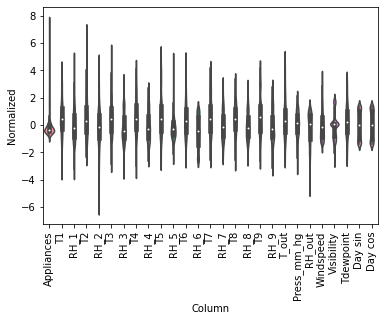

In [23]:
df_std = (df - train_mean)/train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)


## Data windowing

In [24]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Appliances', max_subplots=3):
        inputs, labels = self.example
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [25]:
MAX_EPOCHS = 50

# Launch the training and give us some predictions
def compile_and_fit(model, window, patience=3):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                        epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    
    return history

## Single Step Models

In [26]:
from numpy import single


single_step_window = WindowGenerator(input_width=1,
                                     label_width=1,
                                     shift=1,
                                     label_columns=['Appliances'])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Appliances']

### Baseline

In [27]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [28]:
baseline = Baseline(label_index=column_indices['Appliances'])

baseline.compile(loss=MeanSquaredError(),
                 metrics=[MeanAbsoluteError()])

In [29]:
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 0s 596us/step - loss: 0.7669 - mean_absolute_error: 0.3881


In [30]:
wide_window = WindowGenerator(input_width=24,
                              label_width=24,
                              shift=1,
                              label_columns=['Appliances'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Appliances']

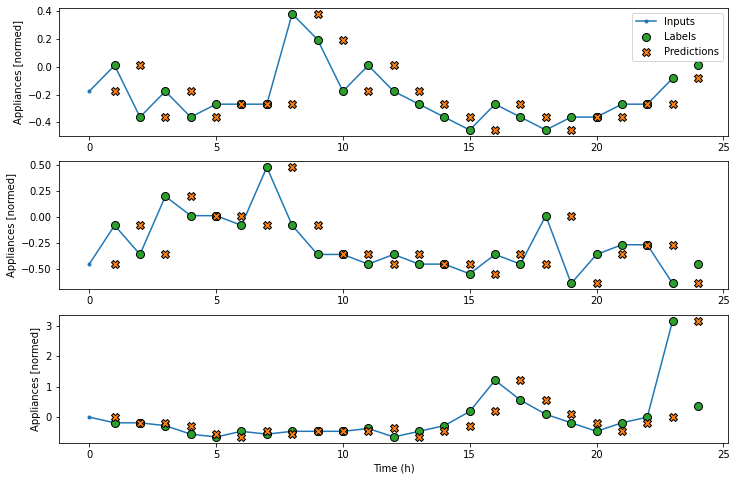

In [31]:
wide_window.plot(baseline)

### Linear model

In [32]:
linear = Sequential([
    Dense(units=1)
])

In [33]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 2ms/step - loss: 2.5893 - mean_absolute_error: 1.1938 - val_loss: 2.4085 - val_mean_absolute_error: 1.1598
Epoch 2/50
72/72 [==============================] - 0s 1ms/step - loss: 1.8732 - mean_absolute_error: 0.9654 - val_loss: 1.7793 - val_mean_absolute_error: 0.9724
Epoch 3/50
72/72 [==============================] - 0s 1ms/step - loss: 1.5635 - mean_absolute_error: 0.8529 - val_loss: 1.4706 - val_mean_absolute_error: 0.8693
Epoch 4/50
72/72 [==============================] - 0s 1ms/step - loss: 1.3863 - mean_absolute_error: 0.7832 - val_loss: 1.2652 - val_mean_absolute_error: 0.7892
Epoch 5/50
72/72 [==============================] - 0s 1ms/step - loss: 1.2616 - mean_absolute_error: 0.7278 - val_loss: 1.1024 - val_mean_absolute_error: 0.7177
Epoch 6/50
72/72 [==============================] - 0s 1ms/step - loss: 1.1667 - mean_absolute_error: 0.6842 - val_loss: 0.9795 - val_mean_absolute_error: 0.6598
Epoch 7/50
72/72 [==========

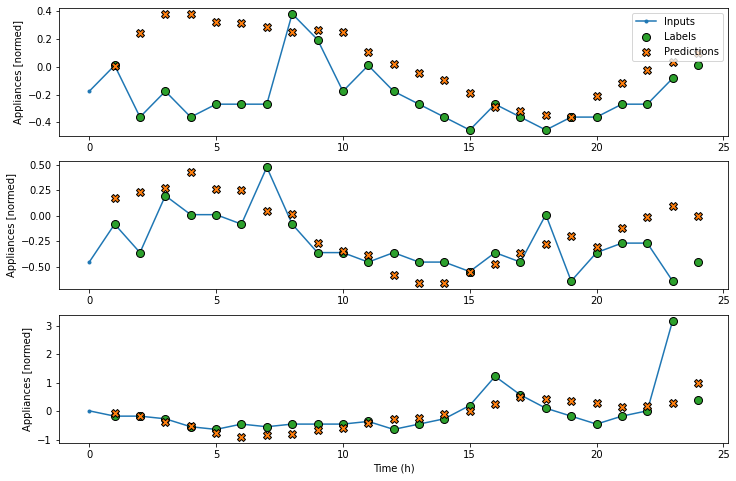

In [34]:
wide_window.plot(linear)

### Dense

In [35]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1),
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 3ms/step - loss: 0.9392 - mean_absolute_error: 0.5708 - val_loss: 0.6637 - val_mean_absolute_error: 0.5509
Epoch 2/50
72/72 [==============================] - 0s 1ms/step - loss: 0.8102 - mean_absolute_error: 0.5181 - val_loss: 0.5918 - val_mean_absolute_error: 0.4543
Epoch 3/50
72/72 [==============================] - 0s 1ms/step - loss: 0.7832 - mean_absolute_error: 0.5121 - val_loss: 0.6018 - val_mean_absolute_error: 0.4470
Epoch 4/50
72/72 [==============================] - 0s 1ms/step - loss: 0.7635 - mean_absolute_error: 0.5067 - val_loss: 0.6041 - val_mean_absolute_error: 0.4593
Epoch 5/50
21/21 [==============================] - 0s 588us/step - loss: 0.5947 - mean_absolute_error: 0.4553


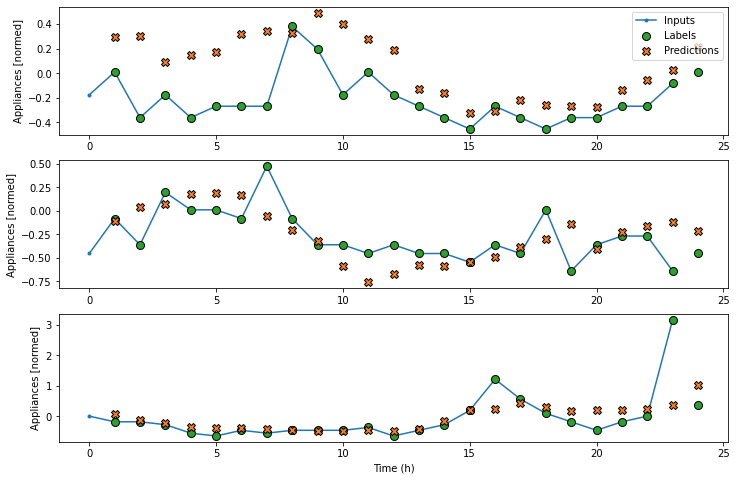

In [36]:
wide_window.plot(dense)

### CNN - Convolutional Neural Network

In [37]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Appliances']
)

In [38]:
from cProfile import label


LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Appliances']
)

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Appliances']

In [39]:
cnn_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 3ms/step - loss: 0.9214 - mean_absolute_error: 0.5735 - val_loss: 0.5812 - val_mean_absolute_error: 0.4487
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.8017 - mean_absolute_error: 0.5125 - val_loss: 0.5755 - val_mean_absolute_error: 0.4567
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7587 - mean_absolute_error: 0.5031 - val_loss: 0.5820 - val_mean_absolute_error: 0.4284
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.7346 - mean_absolute_error: 0.4805 - val_loss: 0.5907 - val_mean_absolute_error: 0.4259
Epoch 5/50
21/21 [==============================] - 0s 752us/step - loss: 0.5910 - mean_absolute_error: 0.4261


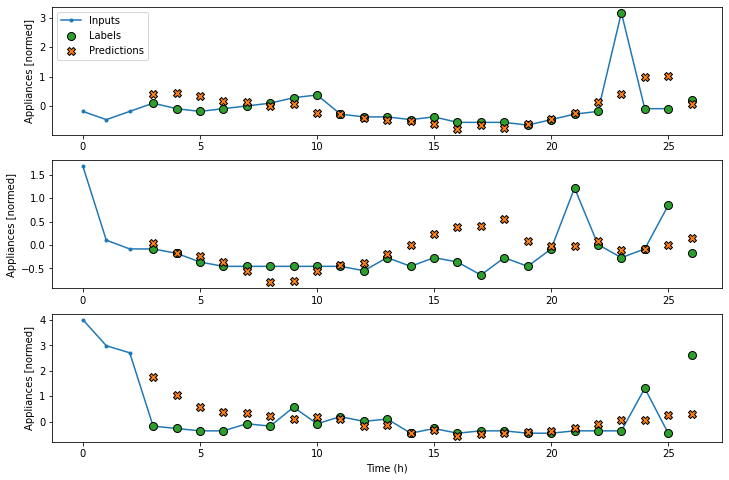

In [40]:
wide_conv_window.plot(cnn_model)

### LSTM - Long Short Term Memory

In [41]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(conv_window.val)
performance['LSTM'] = lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 2s 10ms/step - loss: 0.8607 - mean_absolute_error: 0.5288 - val_loss: 0.5564 - val_mean_absolute_error: 0.4145
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.7529 - mean_absolute_error: 0.4842 - val_loss: 0.5577 - val_mean_absolute_error: 0.4134
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.7042 - mean_absolute_error: 0.4688 - val_loss: 0.5610 - val_mean_absolute_error: 0.4237
Epoch 4/50
21/21 [==============================] - 0s 1ms/step - loss: 0.5572 - mean_absolute_error: 0.4129


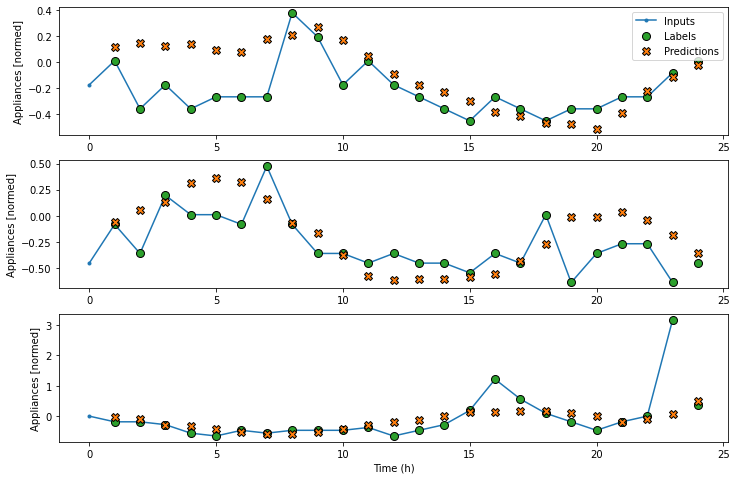

In [42]:
wide_window.plot(lstm_model)

### CNN + LSTM

In [43]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
           kernel_size=(CONV_WIDTH,),
           activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 3s 9ms/step - loss: 0.9543 - mean_absolute_error: 0.5611 - val_loss: 0.5842 - val_mean_absolute_error: 0.4782
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.8296 - mean_absolute_error: 0.5039 - val_loss: 0.5259 - val_mean_absolute_error: 0.3742
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: 0.7907 - mean_absolute_error: 0.4903 - val_loss: 0.5316 - val_mean_absolute_error: 0.3929
Epoch 4/50
72/72 [==============================] - 0s 3ms/step - loss: 0.7663 - mean_absolute_error: 0.4761 - val_loss: 0.5466 - val_mean_absolute_error: 0.3876
Epoch 5/50
21/21 [==============================] - 0s 1ms/step - loss: 0.5529 - mean_absolute_error: 0.3653


### Comparing performances

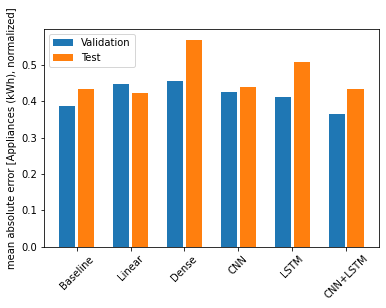

In [44]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean absolute error [Appliances (kWh), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.legend(loc='best')
plt.show()

Linear is our best model in this case, because it has the smaller error for the test set.

In [45]:
for name, value in performance.items():
    print(f'{name}: {value[1]:0.4f}')

Baseline: 0.4342
Linear: 0.4229
Dense: 0.5695
CNN: 0.4387
LSTM: 0.5072
CNN+LSTM: 0.4347


We can see that the CNN + LSTM model did perform closely to the linear model.

## Multi-Output Models

In [46]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1
)

wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1
)

CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'labels shape (batch, time, features): {example_labels.shape}')

inputs shape (batch, time, features): (32, 24, 27)
labels shape (batch, time, features): (32, 24, 27)


### Baseline

In [47]:
baseline = Baseline()
baseline.compile(loss=MeanSquaredError(),
                 metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

20/20 [==============================] - 0s 565us/step - loss: 0.1296 - mean_absolute_error: 0.1775


### Dense

In [48]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_features),
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 1s 3ms/step - loss: 0.6323 - mean_absolute_error: 0.6069 - val_loss: 0.4960 - val_mean_absolute_error: 0.5296
Epoch 2/50
72/72 [==============================] - 0s 1ms/step - loss: 0.2728 - mean_absolute_error: 0.3782 - val_loss: 0.3410 - val_mean_absolute_error: 0.4273
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.1975 - mean_absolute_error: 0.3059 - val_loss: 0.2769 - val_mean_absolute_error: 0.3813
Epoch 4/50
72/72 [==============================] - 0s 1ms/step - loss: 0.1703 - mean_absolute_error: 0.2743 - val_loss: 0.2506 - val_mean_absolute_error: 0.3612
Epoch 5/50
72/72 [==============================] - 0s 1ms/step - loss: 0.1552 - mean_absolute_error: 0.2552 - val_loss: 0.2313 - val_mean_absolute_error: 0.3440
Epoch 6/50
72/72 [==============================] - 0s 1ms/step - loss: 0.1457 - mean_absolute_error: 0.2428 - val_loss: 0.2246 - val_mean_absolute_error: 0.3388
Epoch 7/50
72/72 [==========

### LSTM

In [49]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 2s 11ms/step - loss: 0.7346 - mean_absolute_error: 0.6684 - val_loss: 1.2780 - val_mean_absolute_error: 0.8451
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.3886 - mean_absolute_error: 0.4641 - val_loss: 0.9226 - val_mean_absolute_error: 0.6913
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2829 - mean_absolute_error: 0.3816 - val_loss: 0.7642 - val_mean_absolute_error: 0.6191
Epoch 4/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2333 - mean_absolute_error: 0.3361 - val_loss: 0.6715 - val_mean_absolute_error: 0.5745
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.2027 - mean_absolute_error: 0.3056 - val_loss: 0.5996 - val_mean_absolute_error: 0.5371
Epoch 6/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1815 - mean_absolute_error: 0.2829 - val_loss: 0.5421 - val_mean_absolute_error: 0.5064
Epoch 7/50
72/72 [=========

### CNN + LSTM

In [50]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32,
           kernel_size=(CONV_WIDTH,),
           activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(units=num_features)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 3s 10ms/step - loss: 0.8382 - mean_absolute_error: 0.7254 - val_loss: 1.6657 - val_mean_absolute_error: 0.9561
Epoch 2/50
72/72 [==============================] - 0s 3ms/step - loss: 0.4706 - mean_absolute_error: 0.5129 - val_loss: 0.9743 - val_mean_absolute_error: 0.7183
Epoch 3/50
72/72 [==============================] - 0s 3ms/step - loss: 0.3578 - mean_absolute_error: 0.4352 - val_loss: 0.8304 - val_mean_absolute_error: 0.6536
Epoch 4/50
72/72 [==============================] - 0s 3ms/step - loss: 0.2993 - mean_absolute_error: 0.3896 - val_loss: 0.7331 - val_mean_absolute_error: 0.6131
Epoch 5/50
72/72 [==============================] - 0s 3ms/step - loss: 0.2658 - mean_absolute_error: 0.3623 - val_loss: 0.6844 - val_mean_absolute_error: 0.5916
Epoch 6/50
72/72 [==============================] - 0s 3ms/step - loss: 0.2446 - mean_absolute_error: 0.3438 - val_loss: 0.6726 - val_mean_absolute_error: 0.5815
Epoch 7/50
72/72 [=========

### ResNet - Residual Networks
Just to see if it performs better

It predicts the difference in the labels

In [51]:
class ResidualWrapper(Model):
    def __init__(self, model):
        super().__init__()
        self.model = model 
        
    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        
        return inputs + delta 

In [52]:
res_lstm = ResidualWrapper(
    Sequential([
        LSTM(32, return_sequences=True),
        Dense(
            num_features,
            kernel_initializer=tf.initializers.zeros # Initialize preds to 0
        )
    ])
)

history = compile_and_fit(res_lstm, wide_window)

val_performance['res_lstm'] = res_lstm.evaluate(wide_window.val)
performance['res_lstm'] = res_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 2s 10ms/step - loss: 0.1468 - mean_absolute_error: 0.1675 - val_loss: 0.1117 - val_mean_absolute_error: 0.1568
Epoch 2/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1282 - mean_absolute_error: 0.1571 - val_loss: 0.1043 - val_mean_absolute_error: 0.1593
Epoch 3/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1103 - mean_absolute_error: 0.1543 - val_loss: 0.1024 - val_mean_absolute_error: 0.1618
Epoch 4/50
72/72 [==============================] - 0s 6ms/step - loss: 0.1022 - mean_absolute_error: 0.1524 - val_loss: 0.1037 - val_mean_absolute_error: 0.1650
Epoch 5/50
72/72 [==============================] - 0s 6ms/step - loss: 0.0977 - mean_absolute_error: 0.1510 - val_loss: 0.1035 - val_mean_absolute_error: 0.1656
Epoch 6/50
20/20 [==============================] - 0s 2ms/step - loss: 0.1054 - mean_absolute_error: 0.1683


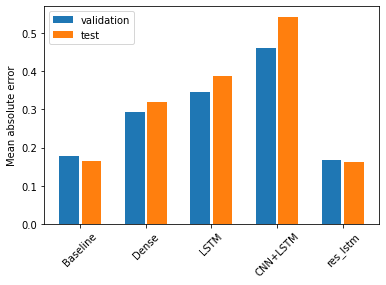

In [53]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_abolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('Mean absolute error')
plt.bar(x - 0.17, val_mae, width, label='validation')
plt.bar(x + 0.17, test_mae, width, label='test')
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
plt.legend(loc='best')
plt.show()

We can see it got progressively worse as we increase the complexity of the networks. But the residual lstm seems to have perform quite well.


In [54]:
for name, value in performance.items():
    print(f'{name:12s} {value[1]:0.4f}')

Baseline     0.1658
Dense        0.3184
LSTM         0.3869
CNN+LSTM     0.5437
res_lstm     0.1627


The residual lstm did perform a little better than the baseline. We could also try to change the architecture of the models to try to have a better performance.

## Multi-Step Models

We arte going to predict sequences of predictions. We are going to predict the next 24 hours.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

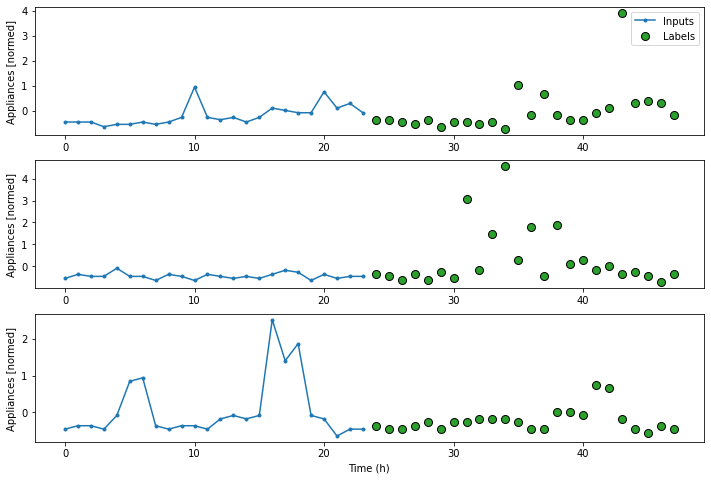

In [55]:
OUT_STEPS = 24

multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS
)

multi_window.plot()
multi_window

### Baseline

In [56]:
class MultiStepLastBaseline(Model):
    def call(self, inputs):
        return tf.tile(inputs[:,-1:,:], [1, OUT_STEPS, 1])

In [57]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=MeanSquaredError(),
                     metrics=[MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 616us/step - loss: 0.9511 - mean_absolute_error: 0.6514


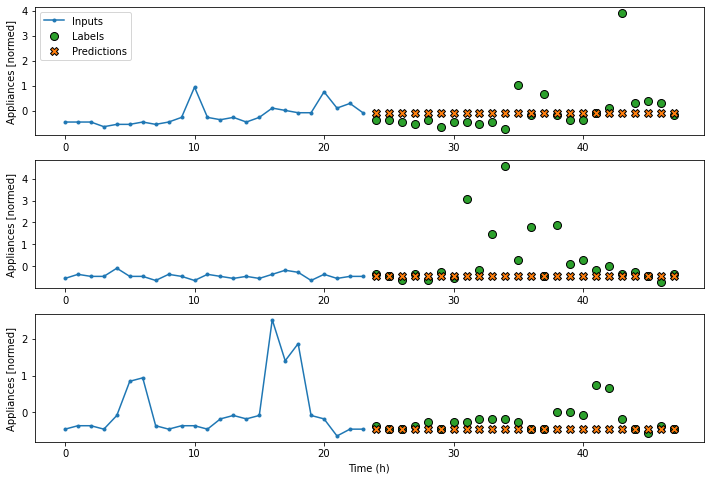

In [58]:
multi_window.plot(last_baseline)

In [59]:
class RepeatBaseline(Model):
    def call(self, inputs):
        return inputs

In [60]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=MeanSquaredError(),
                        metrics=[MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 614us/step - loss: 0.5227 - mean_absolute_error: 0.4846


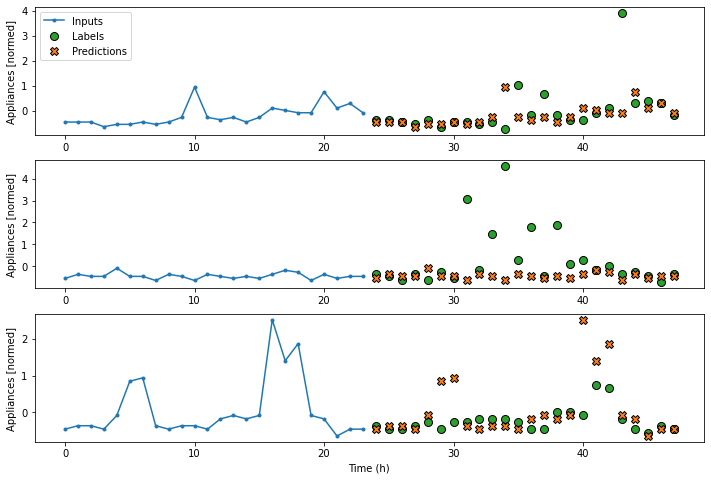

In [61]:
multi_window.plot(repeat_baseline)

### Linear Model - Single shot
Predict the next 24 hours in one shot

In [62]:
multi_linear_model = Sequential([
    # Take the last time step
    Lambda(lambda x: x[:, -1:, :]), # Shape[btach, time, features] becomes => [batch, 1, features]
    Dense(OUT_STEPS*num_features,
          kernel_initializer=tf.initializers.zeros), # Shape[batch, 1, OUT_STEPS*num_features]
    Reshape([OUT_STEPS, num_features]) # Shape [batch, out_steps, num_features]
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 0s 2ms/step - loss: 0.6998 - mean_absolute_error: 0.6583 - val_loss: 0.9444 - val_mean_absolute_error: 0.7263
Epoch 2/50
71/71 [==============================] - 0s 2ms/step - loss: 0.4657 - mean_absolute_error: 0.5157 - val_loss: 0.7163 - val_mean_absolute_error: 0.6073
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 0.4082 - mean_absolute_error: 0.4730 - val_loss: 0.6592 - val_mean_absolute_error: 0.5749
Epoch 4/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3798 - mean_absolute_error: 0.4512 - val_loss: 0.6274 - val_mean_absolute_error: 0.5568
Epoch 5/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3620 - mean_absolute_error: 0.4370 - val_loss: 0.6068 - val_mean_absolute_error: 0.5455
Epoch 6/50
71/71 [==============================] - 0s 1ms/step - loss: 0.3494 - mean_absolute_error: 0.4265 - val_loss: 0.5886 - val_mean_absolute_error: 0.5344
Epoch 7/50
71/71 [==========

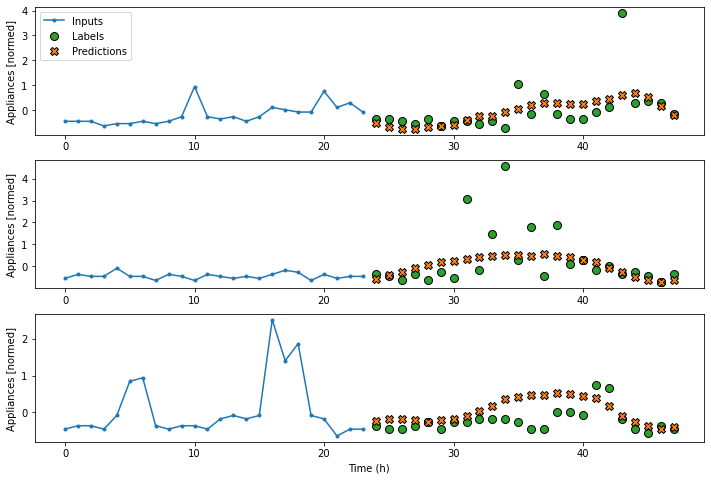

In [63]:
multi_window.plot(multi_linear_model)

### Dense - Single shot

In [64]:
multi_dense_model = Sequential([
    Lambda(lambda x: x[:, -1:, :]),
    Dense(units=512, activation='relu'),
    Dense(OUT_STEPS*num_features,
          kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 3ms/step - loss: 0.4639 - mean_absolute_error: 0.5010 - val_loss: 0.6427 - val_mean_absolute_error: 0.5550
Epoch 2/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2995 - mean_absolute_error: 0.3766 - val_loss: 0.6279 - val_mean_absolute_error: 0.5377
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2776 - mean_absolute_error: 0.3554 - val_loss: 0.5960 - val_mean_absolute_error: 0.5230
Epoch 4/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2649 - mean_absolute_error: 0.3441 - val_loss: 0.5998 - val_mean_absolute_error: 0.5220
Epoch 5/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2546 - mean_absolute_error: 0.3349 - val_loss: 0.6111 - val_mean_absolute_error: 0.5240
Epoch 6/50
20/20 [==============================] - 0s 871us/step - loss: 0.6059 - mean_absolute_error: 0.5237


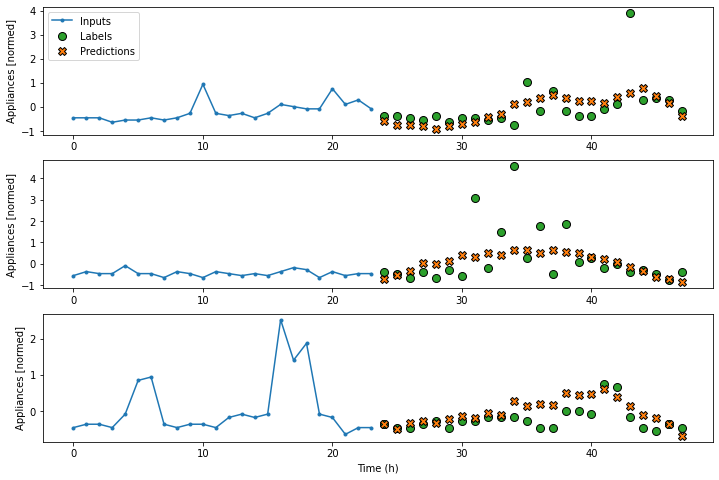

In [65]:
multi_window.plot(multi_dense_model)

### CNN - Single Shot

In [66]:
CONV_WIDTH = 3

multi_conv_model = Sequential([
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    Dense(OUT_STEPS*num_features,
          kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['CNN'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 1s 4ms/step - loss: 0.4880 - mean_absolute_error: 0.5178 - val_loss: 0.6501 - val_mean_absolute_error: 0.5744
Epoch 2/50
71/71 [==============================] - 0s 2ms/step - loss: 0.3104 - mean_absolute_error: 0.3877 - val_loss: 0.6028 - val_mean_absolute_error: 0.5406
Epoch 3/50
71/71 [==============================] - 0s 2ms/step - loss: 0.2836 - mean_absolute_error: 0.3633 - val_loss: 0.6245 - val_mean_absolute_error: 0.5484
Epoch 4/50
71/71 [==============================] - 0s 3ms/step - loss: 0.2671 - mean_absolute_error: 0.3487 - val_loss: 0.6120 - val_mean_absolute_error: 0.5402
Epoch 5/50
20/20 [==============================] - 0s 955us/step - loss: 0.6208 - mean_absolute_error: 0.5395


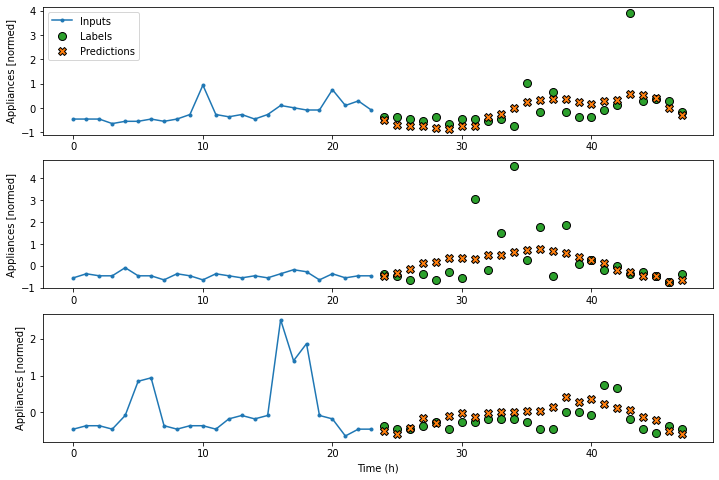

In [67]:
multi_window.plot(multi_conv_model)

### LSTM - Single Shot

In [68]:
multi_lstm_model = Sequential([
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features,
          kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 2s 10ms/step - loss: 0.7726 - mean_absolute_error: 0.6923 - val_loss: 1.5765 - val_mean_absolute_error: 0.9415
Epoch 2/50
71/71 [==============================] - 0s 6ms/step - loss: 0.5367 - mean_absolute_error: 0.5575 - val_loss: 1.4071 - val_mean_absolute_error: 0.8826
Epoch 3/50
71/71 [==============================] - 0s 6ms/step - loss: 0.4572 - mean_absolute_error: 0.5072 - val_loss: 1.2811 - val_mean_absolute_error: 0.8410
Epoch 4/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3775 - mean_absolute_error: 0.4508 - val_loss: 1.1397 - val_mean_absolute_error: 0.7851
Epoch 5/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3281 - mean_absolute_error: 0.4088 - val_loss: 1.1052 - val_mean_absolute_error: 0.7708
Epoch 6/50
71/71 [==============================] - 0s 6ms/step - loss: 0.3085 - mean_absolute_error: 0.3917 - val_loss: 1.1018 - val_mean_absolute_error: 0.7707
Epoch 7/50
71/71 [=========

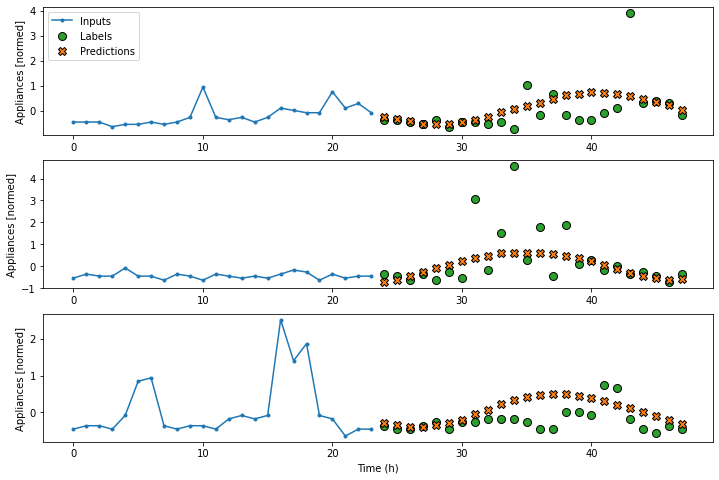

In [69]:
multi_window.plot(multi_lstm_model)

### CNN + LSTM - Single Shot

In [70]:
multi_cnn_lstm_model = Sequential([
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]), 
    Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features,
          kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_cnn_lstm_model, multi_window)

multi_val_performance['CNN+LSTM'] = multi_cnn_lstm_model.evaluate(multi_window.val)
multi_performance['CNN+LSTM'] = multi_cnn_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 3s 10ms/step - loss: 0.8645 - mean_absolute_error: 0.7396 - val_loss: 1.6207 - val_mean_absolute_error: 0.9436
Epoch 2/50
71/71 [==============================] - 0s 4ms/step - loss: 0.5824 - mean_absolute_error: 0.5826 - val_loss: 1.3810 - val_mean_absolute_error: 0.8774
Epoch 3/50
71/71 [==============================] - 0s 4ms/step - loss: 0.5234 - mean_absolute_error: 0.5453 - val_loss: 1.2662 - val_mean_absolute_error: 0.8455
Epoch 4/50
71/71 [==============================] - 0s 4ms/step - loss: 0.4895 - mean_absolute_error: 0.5243 - val_loss: 1.1760 - val_mean_absolute_error: 0.8135
Epoch 5/50
71/71 [==============================] - 0s 4ms/step - loss: 0.4391 - mean_absolute_error: 0.4927 - val_loss: 1.1324 - val_mean_absolute_error: 0.7964
Epoch 6/50
71/71 [==============================] - 0s 4ms/step - loss: 0.3743 - mean_absolute_error: 0.4469 - val_loss: 1.0814 - val_mean_absolute_error: 0.7628
Epoch 7/50
71/71 [=========

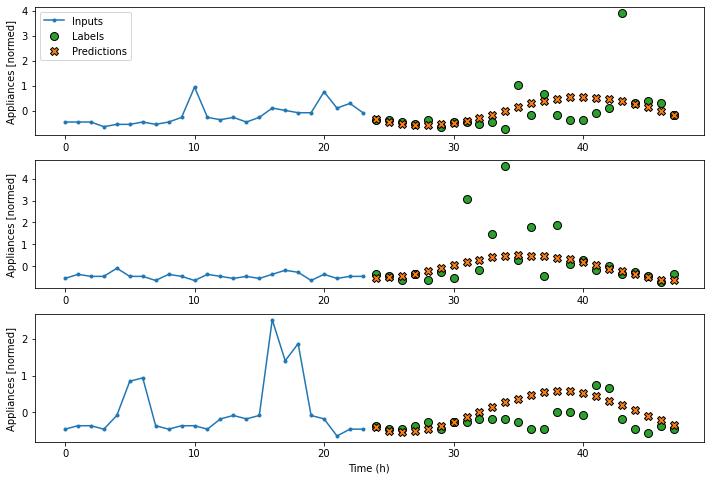

In [71]:
multi_window.plot(multi_cnn_lstm_model)

### LSTM - Autoregressive

In [72]:
class FeedBack(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        
        return prediction, state 
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            prediction = self.dense(x)
            predictions.append(prediction)
            
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [74]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

history = compile_and_fit(feedback_model, multi_window)   

multi_val_performance['LSTM-AR'] = feedback_model.evaluate(multi_window.val)
multi_performance['LSTM-AR'] = feedback_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 4s 16ms/step - loss: 0.7785 - mean_absolute_error: 0.6941 - val_loss: 1.5288 - val_mean_absolute_error: 0.9252
Epoch 2/50
71/71 [==============================] - 1s 10ms/step - loss: 0.5517 - mean_absolute_error: 0.5648 - val_loss: 1.4359 - val_mean_absolute_error: 0.8917
Epoch 3/50
71/71 [==============================] - 1s 10ms/step - loss: 0.5042 - mean_absolute_error: 0.5357 - val_loss: 1.3184 - val_mean_absolute_error: 0.8476
Epoch 4/50
71/71 [==============================] - 1s 10ms/step - loss: 0.4604 - mean_absolute_error: 0.5088 - val_loss: 1.2455 - val_mean_absolute_error: 0.8221
Epoch 5/50
71/71 [==============================] - 1s 9ms/step - loss: 0.3949 - mean_absolute_error: 0.4666 - val_loss: 1.1796 - val_mean_absolute_error: 0.7966
Epoch 6/50
71/71 [==============================] - 1s 9ms/step - loss: 0.3446 - mean_absolute_error: 0.4289 - val_loss: 1.2023 - val_mean_absolute_error: 0.7960
Epoch 7/50
71/71 [======

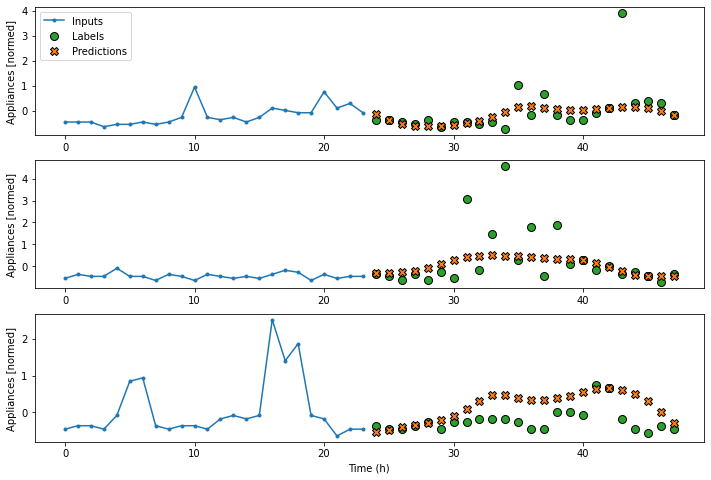

In [75]:
multi_window.plot(feedback_model)

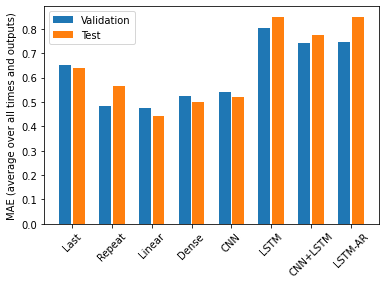

In [76]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
plt.legend(loc='best')
plt.show()

In [77]:
for name, value in multi_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Last        : 0.6389
Repeat      : 0.5648
Linear      : 0.4440
Dense       : 0.4989
CNN         : 0.5187
LSTM        : 0.8500
CNN+LSTM    : 0.7742
LSTM-AR     : 0.8477


The best three model were the following:
- Linear regression
- Dense model
- CNN model